In [2]:
#Feature Extraction with Univariate Statistical Tests (Chi-squared for classification)
import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline

import os
import sys
import pickle
import cPickle
import codecs
import collections


#something goes wrong here - no print statements possible any longer when doing reload(sys)
#solution: save and redirect the standard output to the ipython notebook
import sys  
stdout = sys.stdout

reload(sys)  
sys.setdefaultencoding('utf8')
sys.getdefaultencoding()

sys.stdout = stdout
sys.path.append("../../Preprocessing")
import extract_utils as eu
import LM_utils as lu


from matplotlib.backends.backend_pdf import PdfPages

In [3]:
print "pandas version, needs to be 0.18+ and is:", pd.__version__
#print "sklearn version, needs to be 0.18+", sklearn.__version__

pandas version, needs to be 0.18+ and is: 0.19.2


# Building dictionaries with value lists 
(final, not final or pause, speech)

In [4]:
'Features'
''''time_in_sec', 'pcm_RMSenergy_sma', 'rms_minus_one', 'rms_minus_two',\
'rms_minus_three', 'rms_minus_four', 'pcm_LOGenergy_sma', 'pcm_loudness_sma',\
'pcm_intensity_sma', 'intensity_mean', 'intensity_slope',\
'voicingFinalUnclipped_sma', 'voicingFinalUnclipped_slope',\

'wml', 'wml_trigram, 'zscore', 'duration', '''

def put_into_dict(speaker, val_dict, feature,\
                  start_last_word, end_last_word, ep_df,\
                 label_list=[], vad=False):
    
    if type(feature) == list:
        for feat in feature:
            val_list = ep_df[[feat]].values.tolist()
            val_list = [val[0] for val in val_list]
            if 'pcm' in feat:
                feat = 'intensity'
            elif 'voicing' in feat:
                if 'sma' in feat:
                    feat = 'F0'
                else:
                    feat = 'F0_slope'
            if vad == True:
                for i in range(len(label_list)):
                    if label_list[i] == 1.0:
                        val_dict[speaker][feat]['speech'].append(val_list[i])                
                    else:
                        val_dict[speaker][feat]['pause'].append(val_list[i])
            else:                
                val_dict[speaker][feat]['final'] += val_list[start_last_word+1:end_last_word]
                val_dict[speaker][feat]['not_final']+= val_list[:start_last_word+1]    
    else:
        val_list = ep_df[[feature]].values.tolist()
        val_list = [val[0] for val in val_list]
        if 'RMS' in feature:
            feat = 'rms'
        elif 'LOG' in feature:
            feat = 'LOGenergy'
        elif 'loudness' in feature:
            feat = 'loudness'
        if vad == True:
            for i in range(len(label_list)):
                if label_list[i] == 1.0:
                    val_dict[speaker][feat]['speech'].append(val_list[i])                
                else:
                    val_dict[speaker][feat]['pause'].append(val_list[i])
        else:
            val_dict[speaker]['final'] += val_list[start_last_word+1:end_last_word]
            val_dict[speaker]['not_final']+= val_list[:start_last_word+1]
    
    return val_dict

#dicts: values per speaker 'final' vs 'not_final'
def build_feature_dicts_acoustic(ep_path='./../../Data/pickled_episodes'):

    rms_dict = {}#rms, minus_value
    logEnergy_dict = {}#pcm_LogEnergy_sma
    intensity_dict = {} #pcm_intensity_sma, mean, slope
    F0_dict = {} #voicingFinalUnclipped, slope, 
    loudness_dict = {} #loudness speaker:final|notfinal 
    time_dict = {}#trp time speaker:list
    vad_dict = {}
    wml_time_dict = {}
    
    feature_dict_list = [('pcm_RMSenergy_sma',rms_dict),\
                         ('pcm_LOGenergy_sma',logEnergy_dict),\
                         ('pcm_loudness_sma',loudness_dict),\
                         (['pcm_intensity_sma', 'intensity_mean', 'intensity_slope'],intensity_dict),\
                         (['voicingFinalUnclipped_sma', 'voicingFinalUnclipped_slope'],F0_dict)]
    
    last_speaker = 1
    progress_count = 0
    counter = 0
    err_list = []

    all_ep_paths = eu.lsdir(ep_path,'.pkl')
    all_ep_paths = sorted(all_ep_paths)
    
    for eps_path in all_ep_paths:
        speaker = eps_path.split('_')[0][1]
        ep = int(eps_path.split('_')[1].split('.')[0])

        #print speaker,ep
        if int(speaker) == 1:
            continue
            
        if speaker != last_speaker:
            wml_time_dict[speaker] = {'wml':[],'wml_trigram':[], 'entropy':[]} 
            
            rms_dict[speaker] = {'final':[],'not_final':[]}#rms
            vad_dict[speaker] = {}
            vad_dict[speaker]['rms'] = {'speech':[],'pause':[]}
            
            logEnergy_dict[speaker] = {'final':[],'not_final':[]}
            vad_dict[speaker]['LOGenergy'] = {'speech':[],'pause':[]}
                        
            intensity_dict[speaker] = {} #pcm_intensity_sma, mean, slope
            intensity_dict[speaker]['intensity'] = {'final':[],'not_final':[]}
            intensity_dict[speaker]['intensity_mean'] = {'final':[],'not_final':[]}
            intensity_dict[speaker]['intensity_slope'] = {'final':[],'not_final':[]}
            
            vad_dict[speaker]['intensity'] = {'speech':[],'pause':[]}
            vad_dict[speaker]['intensity_mean'] = {'speech':[],'pause':[]}
            vad_dict[speaker]['intensity_slope'] = {'speech':[],'pause':[]}
            
            F0_dict[speaker] = {}#voicingFinalUnclipped, slope, 
            F0_dict[speaker]['F0'] = {'final':[],'not_final':[]}
            F0_dict[speaker]['F0_slope'] = {'final':[],'not_final':[]}
            vad_dict[speaker]['F0'] = {'speech':[],'pause':[]}
            vad_dict[speaker]['F0_slope'] = {'speech':[],'pause':[]}
            
            loudness_dict[speaker] = {'final':[],'not_final':[]} #loudness speaker:final|notfinal 
            vad_dict[speaker]['loudness'] = {'speech':[],'pause':[]}
            
            time_dict[speaker] = []
            
            print speaker
            last_speaker = speaker                
            progress_count = 0
            print 'errors in (speaker, episode): ',set(err_list)
            err_list = []
            
        if progress_count!=0 and progress_count%50==0:
            print 'progress',progress_count
        
        eppath = ep_path+"/r"+str(speaker)+"/"
        ep_df = eu.open_pkl_ep(speaker, ep, eppath)
        
        if 'pcm_RMSenergy_sma' not in ep_df.keys():
            print 'not in dictionary',speaker, ep
            continue
        
        time_val = ep_df[ep_df['label_dur']==0.01][ep_df['label']==2].time_in_sec.values.tolist()[0]
        wml_vals = ep_df.wml.values.tolist()
        wml_tri_vals = ep_df.wml_trigram.values.tolist()
        entropy_vals = ep_df.entropy.values.tolist()
        lwml = -4
        for i in range(len(wml_vals)):
            if wml_vals[i] != lwml:
                #relative percentaFge of time elapsed in episode in utterance
                #100/(trp_time/time_x)
                timeX = 100/(time_val/((i+1)/100.0))
                wml_time_dict[speaker]['entropy'].append((entropy_vals[i], timeX))
                wml_time_dict[speaker]['wml'].append((wml_vals[i], timeX))
                wml_time_dict[speaker]['wml_trigram'].append((wml_tri_vals[i], timeX))
                lwml = wml_vals[i]
                
        time_dict[speaker].append(time_val)
        #if time_val > 10.0:
        #    print speaker, ep, time_val
        
        words = ep_df.gold_words.tolist()
        labels = ep_df.label.tolist()
        current_words = ep_df.gold_current_word.values.tolist() 
        end_last_word = int(time_val*100)-3
        
        lcw = words[-1].split(';')[-2]
        #print words[-1]
        #break
        for i in range(end_last_word,0,-1):
            if lcw != current_words[i]:
                start_last_word = i+1
                break
        #print end_last_word, start_last_word
        #break
        
        for feat, val_dict in feature_dict_list:
            val_dict = put_into_dict(speaker, val_dict, feat,\
                      start_last_word, end_last_word, ep_df)
            vad_dict = put_into_dict(speaker, vad_dict, feat,\
                                    start_last_word, end_last_word,\
                                     ep_df, labels, vad=True)
        #print intensity_dict['2']['intensity']['not_final'][:3]
        #break
        progress_count += 1
    
    return vad_dict, rms_dict, logEnergy_dict, intensity_dict,\
F0_dict, loudness_dict, time_dict, wml_time_dict

In [15]:
#'./../../Data/pickled_episodes_2'
ep_path = "../../eot_detection_data/Data/pickled_episodes"
vad_dict, rms_dict, logEnergy_dict, intensity_dict,\
F0_dict, loudness_dict, time_dict, wml_time_dict =\
build_feature_dicts_acoustic(ep_path=ep_path)

In [26]:
def build_feature_dicts(ep_path='./../../Data/pickled_episodes',\
                utt_path='./utterances_for_LM.txt',\
                tg_path = './../../Data/tg_eps'):
    
    utt_file = codecs.open(utt_path,"r","utf8")
    utts = utt_file.readlines()
    utts = [utt.strip() for utt in utts]
    utts = [utt.replace('MTP','') for utt in utts]
    
    utt_dict = {str(sp):[] for sp in range(2,8)}
    for utt in utts:
        utt_dict[utt[0]].append(utt[1:]) 
        
    #wml_file = codecs.open('wml_statistics.csv','w','utf8')
    
    zscore_dict = {}
    dur_dict = {}
    wml_dict = {}
    
    fword = -2#4
    last_speaker = 1
    progress_count = 0
    counter = 0

    tgfiles = eu.lsdir(tg_path, '.TextGrid')
    all_ep_paths = eu.lsdir(ep_path,'.pkl')
    all_ep_paths = sorted(all_ep_paths)
    eps_dict = lu.get_eps_from_pathslist(all_ep_paths)
    print eps_dict.keys()
    eps_dict[3].append(202)
    eps_dict[3] = sorted(eps_dict[3])
    
    for speaker in range(2,8):
        print speaker
        
        #build lm with exclude = speaker
        #only once
        lm = lu.build_lm(utt_path, eps_dict, speaker, 2, False)
        print 'build duration dictionary for zscores'
        #final_dur_dict, dict2, dict3 = eu.get_pho_dicts_final(tg_path, tgfiles, fword)
        #build dictionary for zscore and duration
        print 'zscore and duration dictionary'
        #zscore_dict, dur_dict = eu.get_zscore_final(final_dur_dict,  zscore_dict, dur_dict)
        #dur_list_for_speaker = get_durations_for_speaker(tg_path, int(speaker), eps_dict[int(speaker)])
        print 'apply lm for speaker',speaker
        wml_dict[str(speaker)] = {'final':{'wml':[],'wml_trigram':[],\
                                           'wml_slope':[],'wml_trigram_slope':[],\
                                           'wml_deviation':[], 'wml_trigram_deviation':[]},\
                                  'not_final':{'wml':[],'wml_trigram':[],\
                                               'wml_slope':[],'wml_trigram_slope':[],\
                                               'wml_deviation':[], 'wml_trigram_deviation':[]}}
        
        #apply lm on utterance list -> read_corpus function   
        last_lwbi = -3
        last_lwbi_two = -3
        print 'utterances for speaker',speaker,len(utt_dict[str(speaker)])
        for utt in utt_dict[str(speaker)]:
            
            eot_ngram = utt[1:].strip().encode("utf8")
            eot_ngram = ["<s>","<s>"]+eot_ngram.split(" ")[1:]
            eot_ngram = [en for en in eot_ngram if en != '']
            
            for i in range(2,len(eot_ngram)): 
                #word = eot_ngram[i].strip().encode("utf8") 
                eot_ngram_wml = eot_ngram[:i]+["</s>"]
                eot_ngram_two = eot_ngram_wml[-3:i]+["</s>"]
                
                if eot_ngram_two == ['<s>','<s>','</s>']:
                    lwbi = -3
                    lwbi_two = -3  
                    lwbi_root = 0
                    lwbi_trigram_root = 0
                    deviation_lwbi = lwbi_root
                    deviation_lwbi_two = lwbi_trigram_root
                else:
                    lwbi = lm.logprob_weighted_by_inverse_unigram_logprob(eot_ngram_wml)
                    lwbi_two = lm.logprob_weighted_by_inverse_unigram_logprob(eot_ngram_two)
                    if i == 1:
                        lwbi_root = lwbi
                        lwbi_trigram_root = lwbi_two 
                        deviation_lwbi = lwbi_root
                        deviation_lwbi_two = lwbi_trigram_root
                    else:
                        deviation_lwbi = lwbi - lwbi_root
                        deviation_lwbi_two = lwbi_two - lwbi_trigram_root
                
                slope_lwbi = lwbi-last_lwbi
                slope_lwbi_two = lwbi_two-last_lwbi_two
                
                
                
                if i < len(eot_ngram)-3:
                    wml_dict[str(speaker)]['not_final']['wml'].append(lwbi)
                    wml_dict[str(speaker)]['not_final']['wml_trigram'].append(lwbi_two)
                    wml_dict[str(speaker)]['not_final']['wml_slope'].append(slope_lwbi)
                    wml_dict[str(speaker)]['not_final']['wml_trigram_slope'].append(slope_lwbi_two)
                    wml_dict[str(speaker)]['not_final']['wml_trigram_deviation'].append(deviation_lwbi_two)
                    wml_dict[str(speaker)]['not_final']['wml_deviation'].append(deviation_lwbi)
                else:
                    wml_dict[str(speaker)]['final']['wml'].append(lwbi)
                    wml_dict[str(speaker)]['final']['wml_trigram'].append(lwbi_two)
                    wml_dict[str(speaker)]['final']['wml_slope'].append(slope_lwbi)
                    wml_dict[str(speaker)]['final']['wml_trigram_slope'].append(slope_lwbi_two)
                    wml_dict[str(speaker)]['final']['wml_trigram_deviation'].append(deviation_lwbi_two)
                    wml_dict[str(speaker)]['final']['wml_deviation'].append(deviation_lwbi)
                
                last_lwbi = lwbi
                last_lwbi_two = lwbi_two
                
    #write dicts to file
            
    #wml_file.close()
    utt_file.close()
    return zscore_dict, dur_dict, wml_dict

In [27]:
#'./../../Data/pickled_episodes_2'
ep_path = "../../../../eot_detection_data/Data/pickled_episodes/"
zscore_dict, dur_dict, wml_dict =\
build_feature_dicts(ep_path=ep_path,\
                utt_path='../../Preprocessing/utterances_for_LM.txt',\
                tg_path = '../../../../eot_detection_data/Data/textgrids')

[2, 3, 4, 5, 6, 7]
2
training corpus from ../../Preprocessing/utterances_for_LM.txt
reading corpus excluding speaker 2
excluded corpus
training corpus is a string
Training on standard data...
TOTAL WORDS TRAINED ON = 5241
using heldout corpus
training corpus is a string
Training on heldout data...
unknown words in heldout data 36
TOTAL WORDS TRAINED ON = 6015
6015 total words of training data
1-grams = 302
2-grams = 1500
3-grams = 2675
build duration dictionary for zscores
zscore and duration dictionary
apply lm for speaker 2
utterances for speaker 2 83
3
training corpus from ../../Preprocessing/utterances_for_LM.txt
reading corpus excluding speaker 3
excluded corpus
training corpus is a string
Training on standard data...
TOTAL WORDS TRAINED ON = 5124
using heldout corpus
training corpus is a string
Training on heldout data...
unknown words in heldout data 29
TOTAL WORDS TRAINED ON = 5843
5843 total words of training data
1-grams = 332
2-grams = 1642
3-grams = 2863
build duration dict

In [29]:
print "Features:"
#print "\n".join(sorted(vad_dict['3'].keys()))
print "\n".join(sorted(wml_dict['3']['not_final'].keys()))
print 'zscore'
print 'duration'
print 'wml deviation and slope are derived just for analysis'

Features:
wml
wml_deviation
wml_slope
wml_trigram
wml_trigram_deviation
wml_trigram_slope
zscore
duration
wml deviation and slope are derived just for analysis


# Print mean and standard deviation 
(zscore, duration, wml) per speaker

In [30]:
vowels = [u'Y', u'y:', u'u:', u'aI', u'aU', u'o:',\
              u'9', u'i:', u'E', u'y:6', u'I', u'E:', u'O', \
              u'U',  u'e:', u'a:', u'a',  u'e', u'i',\
              u'o', u'u', u'OY', u'6', u'@', u'n', u'm', u'f', u's', u'S']

def get_mean_and_std(val_list):
    val_mean = np.mean(val_list)
    val_std = np.std(val_list)
    return val_mean, val_std

def get_val_list(sp, val_dict, phones, phone_name=''):
    vals_final = []
    vals_not_final = []
    phone_exist = False
    for speaker in sorted(val_dict.keys()):
        if speaker != 'r'+str(sp):
            if phone_name != '':
                #print phone_name
                try:
                    vals_final += val_dict[str(speaker)][phone_name]['final']
                    if speaker == 2:
                        phone_exist = True
                except KeyError:
                    if phone_exist:
                        vals_final += []
                try:
                    vals_not_final += val_dict[str(speaker)][phone_name]['not_final']
                    if speaker == 2:
                        phone_exist = True
                except KeyError:
                    if phone_exist:
                        vals_not_final += []                               
            else:
                for phone in val_dict[str(speaker)].keys():
                    if phone in phones:
                        vals_final += val_dict[str(speaker)][phone]['final']
                        vals_not_final += val_dict[str(speaker)][phone]['not_final']
    return vals_final, vals_not_final


In [31]:
#average per speaker
#zscore_dict, dur_dict, wml_dict
#zscore_dict[file_id][phone][condition]
# wml_dict[str(speaker)]['not_final']['wml']
# wml_dict[str(speaker)]['final']['wml_trigram']

for speaker in range(2,8):
    print '\n\n heldout ', speaker
    zsc_vals_final, zsc_vals_not_final = get_val_list(speaker, zscore_dict, vowels)
    dur_vals_final, dur_vals_not_final = get_val_list(speaker, dur_dict, vowels)
    wml_vals_final = []
    wml_vals_not_final = []
    wml_tri_vals_final = []
    wml_tri_vals_not_final = []
    for sp in range(2,8):
        if sp != speaker:
            wml_vals_final += wml_dict[str(sp)]['final']['wml']
            wml_vals_not_final += wml_dict[str(sp)]['not_final']['wml']
            wml_tri_vals_final += wml_dict[str(sp)]['final']['wml_trigram']
            wml_tri_vals_not_final += wml_dict[str(sp)]['not_final']['wml_trigram']
    
    
    print 'final'
    print 'zscore'
    zsc_meanf, zsc_stdf = get_mean_and_std(zsc_vals_final)
    print zsc_meanf,'\t', zsc_stdf
    print 'duration'
    dur_meanf, dur_stdf = get_mean_and_std(dur_vals_final)
    print dur_meanf,'\t',dur_stdf
    print 'wml'
    wml_meanf, wml_stdf = get_mean_and_std(wml_vals_final)
    wml_tri_meanf, wml_tri_stdf = get_mean_and_std(wml_tri_vals_final)
    print wml_meanf, '\t',wml_stdf
    print wml_tri_meanf,'\t', wml_tri_stdf
    
    print '\n not final'
    print 'zscore'
    zsc_mean, zsc_std = get_mean_and_std(zsc_vals_not_final)
    print zsc_mean,'\t', zsc_std
    print 'duration'
    dur_mean, dur_std = get_mean_and_std(dur_vals_not_final)
    print dur_mean,'\t',dur_std
    print 'wml'
    wml_mean, wml_std = get_mean_and_std(wml_vals_not_final)
    wml_tri_mean, wml_tri_std = get_mean_and_std(wml_tri_vals_not_final)
    print wml_mean, '\t',wml_std
    print wml_tri_mean,'\t', wml_tri_std
    



 heldout  2
final
zscore
nan 	nan
duration
nan 	nan
wml
-0.995053285722 	0.2932043539
-1.02861618279 	0.576910187796

 not final
zscore
nan 	nan
duration
nan 	nan
wml
-1.57127255408 	0.830199971789
-1.59314294172 	0.94099913261


 heldout  3
final
zscore
nan 	nan
duration
nan 	nan
wml
-0.99335552649 	0.27260177361
-1.03097543747 	0.567181110829

 not final
zscore
nan 	nan
duration
nan 	nan
wml
-1.49842478054 	0.79380284449
-1.48293243669 	0.920113518087


 heldout  4
final
zscore
nan 	nan
duration
nan 	nan
wml
-1.05087101611 	0.321841731785
-1.02818269349 	0.605634993617

 not final
zscore
nan 	nan
duration
nan 	nan
wml
-1.52765507316 	0.790817425412
-1.44724138272 	0.943029328003


 heldout  5
final
zscore
nan 	nan
duration
nan 	nan
wml
-1.01094621536 	0.315511837812
-1.04153254724 	0.592219986187

 not final
zscore
nan 	nan
duration
nan 	nan
wml
-1.52104971681 	0.803530415667
-1.51013252599 	0.925124574168


 heldout  6
final
zscore
nan 	nan
duration
nan 	nan
wml
-1.00501335108 	0.

# Plot distribution of values for zscore, duration, WML

In [9]:
#zscore_dict, dur_dict, wml_dict = build_feature_dicts(ep_path='./../../Data/pickled_episodes',\
#                utt_path='./utterances_for_LM.txt',\
#                tg_path = './../../Data/tg_eps')

In [8]:
def get_freq_dist(val_list):    
    freq_dist = collections.Counter(val_list)
    return freq_dist

def get_percentile(val_list, val_mean, val_std):
    
    upper_bound = val_mean+val_std
    lower_bound = val_mean-val_std
    
    val_list = [val for val in val_list if lower_bound < val < upper_bound]
    
    return val_list

def plot_distribution(speaker, feature_dict,\
                     x_lim, y_lim, feature_name, phone_name,\
                      binf, bin_nf, bin_num, rnd_num, title_pdf='./figures/', cumulative = True):
    
    if not os.path.isdir(title_pdf):
        os.makedirs(title_pdf)
    
    if phone_name != '':
        title_pdf += feature_name+'_speaker'+str(speaker)+'_phone_'+phone_name+'.pdf'
    else:
        title_pdf += feature_name+'_speaker'+str(speaker)+'.pdf'
        
    ymax = 100
    
    vowels = [u'Y', u'y:', u'u:', u'aI', u'aU', u'o:',\
              u'9', u'i:', u'E', u'y:6', u'I', u'E:', u'O', \
              u'U',  u'e:', u'a:', u'a',  u'e', u'i',\
              u'o', u'u', u'OY', u'6', u'@', u'n', u'm', u'f', u's', u'S']
    #vowels = [u'Y', u'u:',\
    #          u'9', u'i:',   u'I', u'E:', u'O', \
    #          u'U',  u'e:', u'a:', u'a',  u'e', u'i',\
    #          u'o', u'u', u'OY',  u'f']
    
    if feature_name == "zscore" or feature_name == "duration":
        val_list_final, val_list_not_final = get_val_list(speaker, feature_dict, vowels, phone_name)
        if feature_name == "zscore":
            out_val = -10
        else:
            out_val = -1.0            
    elif 'wml' in feature_name:
        out_val = -3
        val_list_final = []
        val_list_not_final = []
        for sp in range(2,8):
            if sp != speaker:
                val_list_final += feature_dict[str(sp)]['final'][feature_name]
                val_list_not_final += feature_dict[str(sp)]['not_final'][feature_name]                
    else:
        return 'Not a valid feature name'
    
    val_list_final = [round(valf,rnd_num) for valf in val_list_final if valf!=out_val]
    val_list_not_final = [round(valf,rnd_num) for valf in val_list_not_final if valf!=out_val]
    
    val_meanf = np.mean(val_list_final) 
    val_mean = np.mean(val_list_not_final)

    val_stdf = np.std(val_list_final)
    val_std = np.std(val_list_not_final)

    print 'mean final ', val_meanf
    print 'mean_not_final ', val_mean

    print 'sd final ', val_stdf
    print 'sd not final ', val_std
    
    print '\n'
    
    val_list_perc_final = get_percentile(val_list_final, val_meanf, val_stdf)
    val_list_perc_not_final = get_percentile(val_list_not_final, val_mean, val_std)
    
    print len(val_list_perc_final), len(val_list_final)
    print len(val_list_perc_not_final), len(val_list_not_final)
    
    val_mean_percf = np.mean(val_list_perc_final) 
    val_mean_perc = np.mean(val_list_perc_not_final)

    val_std_percf = np.std(val_list_final)
    val_std_perc = np.std(val_list_not_final)

    print 'mean percentile final ', val_mean_percf
    print 'mean percentile not_final ', val_mean_perc

    print 'sd percentile final ', val_std_percf
    print 'sd percentile not final ', val_std_perc

    f_color = 'r'
    nf_color = 'b'
    percf_color = 'y'
    perc_color = 'g'
    
    #val_list_final = val_list_perc_final
    #val_list_not_final = val_list_perc_not_final
    
    if val_list_not_final == [] and val_list_final == []:
            return 'no values', len(val_list_not_final), len(val_list_final)
    
    x_max_vals = [max(val_list) for val_list in [val_list_final,val_list_not_final] if val_list != []]
    x_min_vals = [min(val_list) for val_list in [val_list_final,val_list_not_final] if val_list != []]
    x_min = max(x_max_vals)
    x_max = min(x_min_vals)
    
    with PdfPages(title_pdf) as pdf:
        
        fig = plt.figure(figsize=(7, 5))
    
        if x_lim != []:
            plt.xlim(x_lim[0], x_lim[1])
        else:
            plt.xlim(x_min, x_max)
        plt.ylim(y_lim[0], y_lim[1])

        if val_list_not_final != []:
            n, bins, patches = plt.hist(val_list_not_final, bin_nf, cumulative=cumulative,\
                                        histtype='step',\
                                        weights=[float(ymax)/len(val_list_not_final)]*len(val_list_not_final),\
                                        facecolor=nf_color, color=nf_color, alpha=0.75, label='not_final')
        if val_list_final != []:
            n, bins, patches = plt.hist(val_list_final, binf, cumulative=cumulative,\
                                            histtype='step',\
                                            weights=[float(ymax)/len(val_list_final)]*len(val_list_final),\
                                            facecolor=f_color, color=f_color, alpha=.75, label='final')
        
        #mean
        plt.plot([val_meanf, val_meanf], [0.0, ymax+5], color=f_color, linestyle='-', linewidth=.5,label='mean final')
        plt.plot([val_mean, val_mean], [0.0, ymax+5], color=nf_color, linestyle='-', linewidth=.5,label='mean not final')
        
        #plt.plot([val_mean_percf, val_mean_percf], [0.0, ymax+5], color=percf_color, linestyle='--', linewidth=.5,label='mean perc final')
        #plt.plot([val_mean_perc, val_mean_perc], [0.0, ymax+5], color=perc_color, linestyle='--', linewidth=.5,label='mean perc not final')        
        
        #standard deviation
        plt.plot([val_meanf-val_stdf, val_meanf-val_stdf], [0.0, ymax+5], color=f_color, linestyle='--', linewidth=.5, label='sd final')
        plt.plot([val_meanf+val_stdf, val_meanf+val_stdf], [0.0, ymax+5], color=f_color, linestyle='--', linewidth=0.5)

        plt.plot([val_mean-val_std, val_mean-val_std], [0.0, ymax+5], color=nf_color, linestyle='--', linewidth=.5, label='sd not final')
        plt.plot([val_mean+val_std, val_mean+val_std], [0.0, ymax+5], color=nf_color, linestyle='--', linewidth=0.5)
        
        #percentile
        #plt.plot([val_mean_percf-val_std_percf, val_mean_percf-val_std_percf], [0.0, ymax+5], color=percf_color, linestyle='-', linewidth=.5, label='sd perc final')
        #plt.plot([val_mean_percf+val_std_percf, val_mean_percf+val_std_percf], [0.0, ymax+5], color=percf_color, linestyle='-', linewidth=0.5)

        #plt.plot([val_mean_perc-val_std_perc, val_mean_perc-val_std_perc], [0.0, ymax+5], color=perc_color, linestyle='-', linewidth=.5, label='sd perc not final')
        #plt.plot([val_mean_perc+val_std_perc, val_mean_perc+val_std_perc], [0.0, ymax+5], color=perc_color, linestyle='-', linewidth=0.5)


        plt.ylabel('frequency')
        #plt.yticks([i/100.0 for i in range(100,10)], [str(i) for i in range(100,10)])
        plt.xlabel(feature_name)

        plt.legend(bbox_to_anchor=(1.05, 1), loc = 2, borderaxespad=0.)

        plt.tight_layout()
        pdf.savefig()  # saves the current figure into a pdf page

        ##############################

    plt.show()
    return

In [125]:
vowels = [u'Y', u'y:', u'u:', u'aI', u'aU', u'o:',\
              u'9', u'i:', u'E', u'y:6', u'I', u'E:', u'O', \
              u'U',  u'e:', u'a:', u'a',  u'e', u'i',\
              u'o', u'u', u'OY', u'6', u'@', u'n', u'm', u'f', u's', u'S']
vowels = [vow.encode('utf8') for vow in vowels]
vow_set = set()
for speaker in range(2,8):
    for pho in dur_dict["r"+str(speaker)].keys():
        #print pho,dur_dict["r"+str(speaker)][pho].keys()
        if pho in vowels:
            if speaker > 2 and pho.encode('utf8') not in vow_set:
                print speaker, pho.encode('utf8')
            vow_set.add(pho.encode('utf8'))
print sorted(list(vow_set))
print set(vowels) - set(vow_set)

3 Y
4 9
5 e
6 u
['6', '9', '@', 'E', 'E:', 'I', 'O', 'OY', 'S', 'U', 'Y', 'a', 'a:', 'aI', 'aU', 'e', 'e:', 'f', 'i', 'i:', 'm', 'n', 'o', 'o:', 's', 'u', 'u:', 'y:']
set(['y:6'])


In [146]:
wml_dict['2']['final'].keys()

['wml_trigram_slope',
 'wml_slope',
 'wml_trigram',
 'wml_trigram_deviation',
 'wml',
 'wml_deviation']

2
mean final  -0.989252669039
mean_not_final  -1.19392816635
sd final  0.257737891467
sd not final  0.235716408983


1621 2529
1938 2645
mean percentile final  -0.993294262801
mean percentile not_final  -1.1807997936
sd percentile final  0.257737891467
sd percentile not final  0.235716408983


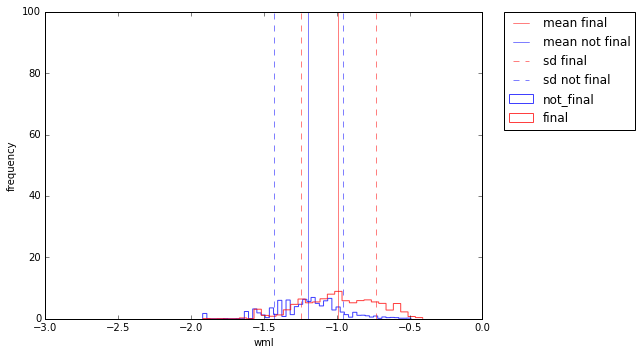

3
mean final  -0.999710467706
mean_not_final  -1.17599929751
sd final  0.246206417286
sd not final  0.206988316042


1495 2245
2139 2847
mean percentile final  -1.01519063545
mean percentile not_final  -1.16097241702
sd percentile final  0.246206417286
sd percentile not final  0.206988316042


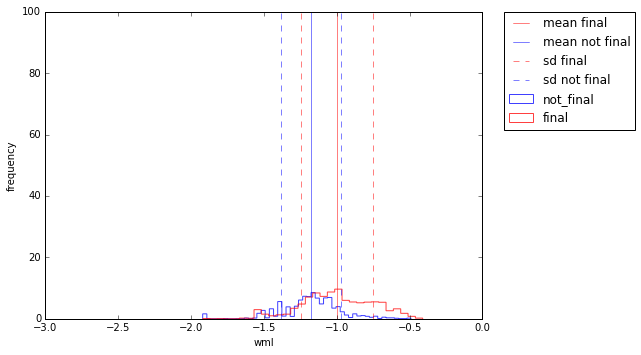

4
mean final  -1.06304757419
mean_not_final  -1.21695618457
sd final  0.244450591065
sd not final  0.217719868366


1444 2123
1892 2579
mean percentile final  -1.08337257618
mean percentile not_final  -1.18655391121
sd percentile final  0.244450591065
sd percentile not final  0.217719868366


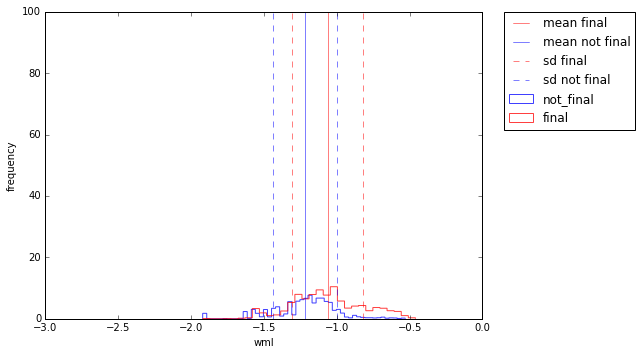

5
mean final  -1.02057520239
mean_not_final  -1.21011490126
sd final  0.265067398618
sd not final  0.219854663297


1534 2347
2027 2785
mean percentile final  -1.05119947849
mean percentile not_final  -1.19285643809
sd percentile final  0.265067398618
sd percentile not final  0.219854663297


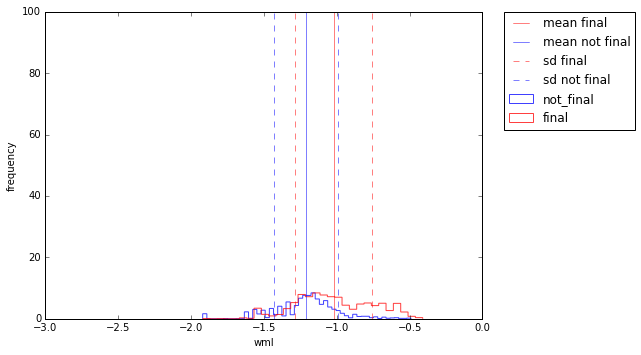

6
mean final  -0.964993486756
mean_not_final  -1.16160081054
sd final  0.253427545892
sd not final  0.233925729516


1487 2303
1359 1974
mean percentile final  -0.956630800269
mean percentile not_final  -1.14791758646
sd percentile final  0.253427545892
sd percentile not final  0.233925729516


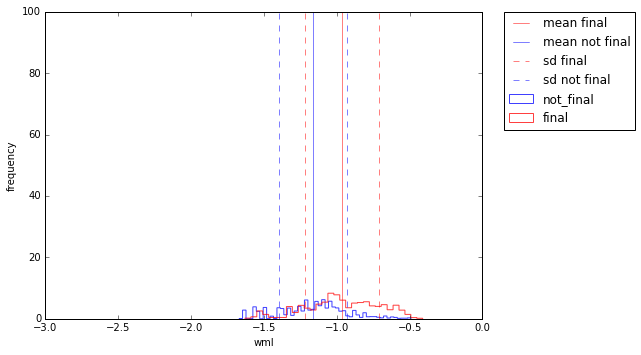

7
mean final  -0.995395083406
mean_not_final  -1.19080661157
sd final  0.243568901275
sd not final  0.214990318343


1459 2278
2301 3025
mean percentile final  -1.01505140507
mean percentile not_final  -1.17807040417
sd percentile final  0.243568901275
sd percentile not final  0.214990318343


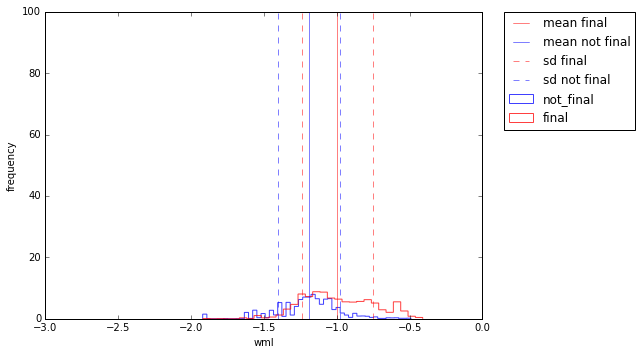

In [115]:
#sp=4
feature_dict = wml_dict
feat_name = 'wml'
#for vow in vowels:
#    print vow
phone_name = ''
for sp in range(2,8):
    print sp
    plot_distribution(sp, feature_dict,\
                          x_lim=[-3,0], y_lim=[0,100], feature_name=feat_name,\
                          phone_name = phone_name, binf=30, bin_nf=50 ,\
                          bin_num=50, rnd_num=2, cumulative = False)

Y
mean final  nan
mean_not_final  -0.000714285714286
sd final  nan
sd not final  0.993070737559


0 0
58 70
mean percentile final  nan
mean percentile not_final  -0.239827586207
sd percentile final  nan
sd percentile not final  0.993070737559


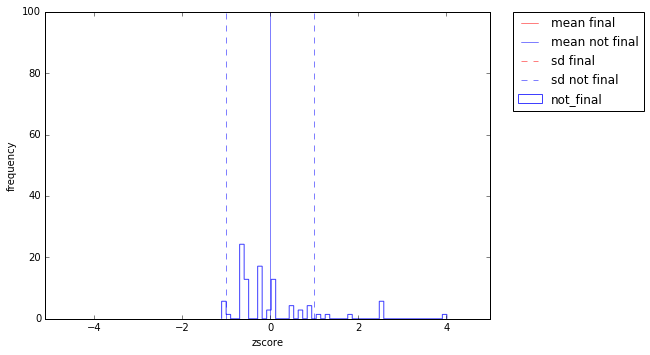

y:
mean final  -0.494444444444
mean_not_final  0.0750420168067
sd final  0.780941185879
sd not final  1.00844907459


13 18
80 119
mean percentile final  -0.610769230769
mean percentile not_final  -0.027875
sd percentile final  0.780941185879
sd percentile not final  1.00844907459


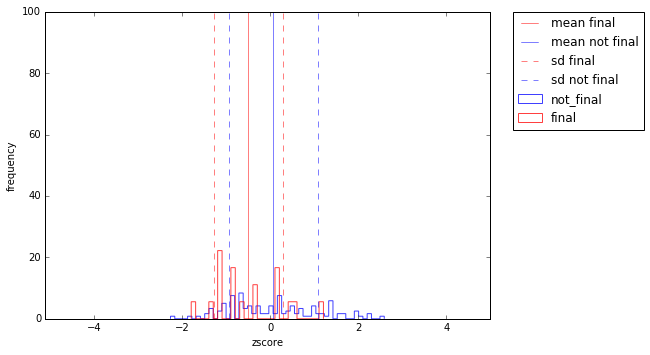

u:
mean final  nan
mean_not_final  2.52323414688e-18
sd final  nan
sd not final  1.00063616129


0 0
32 44
mean percentile final  nan
mean percentile not_final  -0.3071875
sd percentile final  nan
sd percentile not final  1.00063616129


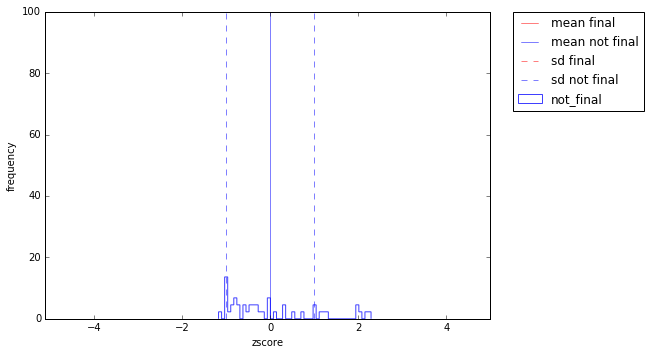

aI
mean final  -0.025
mean_not_final  0.00148867313916
sd final  0.851810164036
sd not final  1.00795431141


14 18
230 309
mean percentile final  -0.256428571429
mean percentile not_final  -0.0144347826087
sd percentile final  0.851810164036
sd percentile not final  1.00795431141


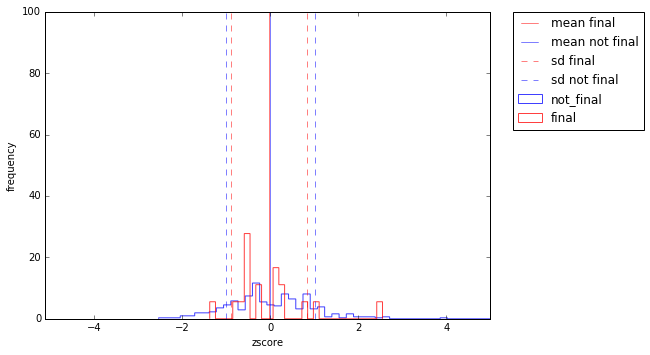

aU
mean final  0.130434782609
mean_not_final  -0.0095873015873
sd final  1.06950406329
sd not final  0.994373131635


13 23
226 315
mean percentile final  0.230769230769
mean percentile not_final  -0.0383628318584
sd percentile final  1.06950406329
sd percentile not final  0.994373131635


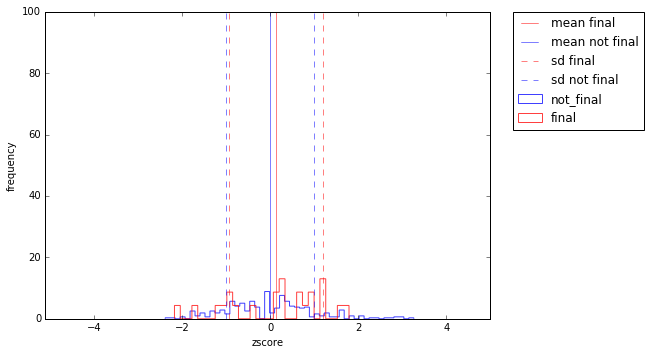

o:
mean final  0.0316666666667
mean_not_final  -0.00397228637413
sd final  0.798713896767
sd not final  1.02442003833


47 60
291 433
mean percentile final  0.0485106382979
mean percentile not_final  0.0383161512027
sd percentile final  0.798713896767
sd percentile not final  1.02442003833


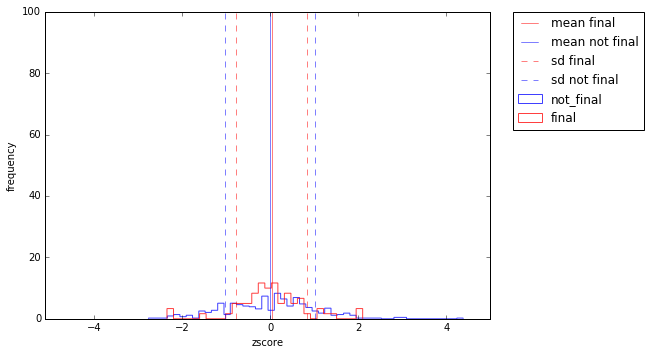

9
mean final  nan
mean_not_final  -0.001875
sd final  nan
sd not final  0.967711338352


0 0
11 16
mean percentile final  nan
mean percentile not_final  0.172727272727
sd percentile final  nan
sd percentile not final  0.967711338352


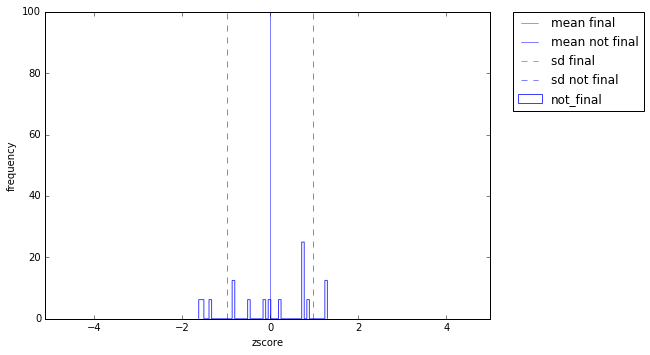

i:
mean final  -0.896666666667
mean_not_final  0.00663438256659
sd final  0.865345146298
sd not final  0.997808035651


1 3
353 413
mean percentile final  -0.78
mean percentile not_final  -0.20388101983
sd percentile final  0.865345146298
sd percentile not final  0.997808035651


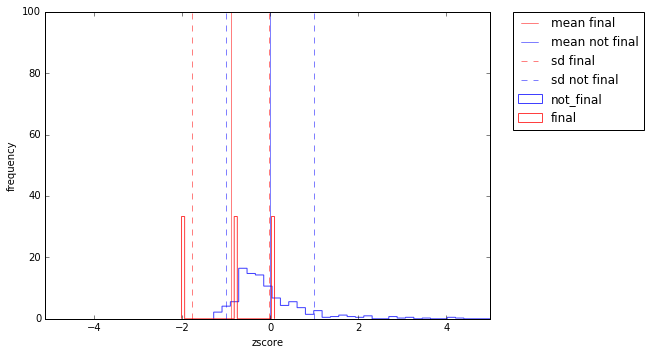

E
mean final  1.04210526316
mean_not_final  -0.0495527950311
sd final  0.884852523825
sd not final  0.977614563512


26 38
570 805
mean percentile final  1.15
mean percentile not_final  -0.076649122807
sd percentile final  0.884852523825
sd percentile not final  0.977614563512


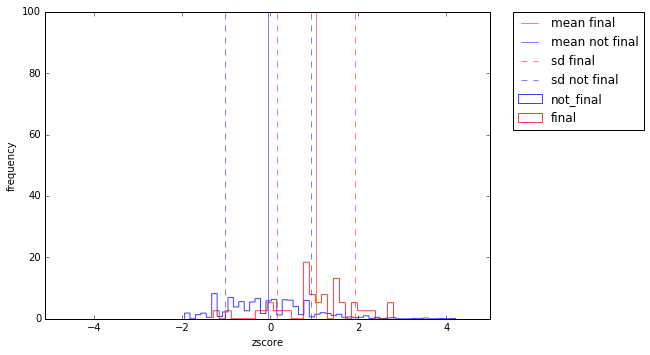

y:6
mean final  nan
mean_not_final  nan
sd final  nan
sd not final  nan


0 0
0 0
mean percentile final  nan
mean percentile not_final  nan
sd percentile final  nan
sd percentile not final  nan
I
mean final  -0.0263636363636
mean_not_final  0.000769230769231
sd final  0.942619876411
sd not final  1.00068695293


8 11
564 819
mean percentile final  -0.36
mean percentile not_final  -0.107021276596
sd percentile final  0.942619876411
sd percentile not final  1.00068695293


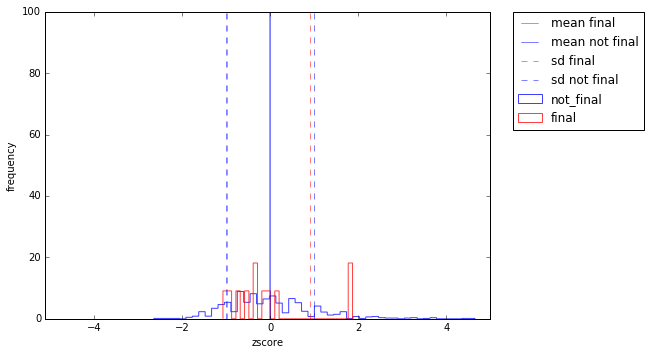

E:
mean final  nan
mean_not_final  0.000888888888889
sd final  nan
sd not final  0.989578635856


0 0
28 45
mean percentile final  nan
mean percentile not_final  -0.1275
sd percentile final  nan
sd percentile not final  0.989578635856


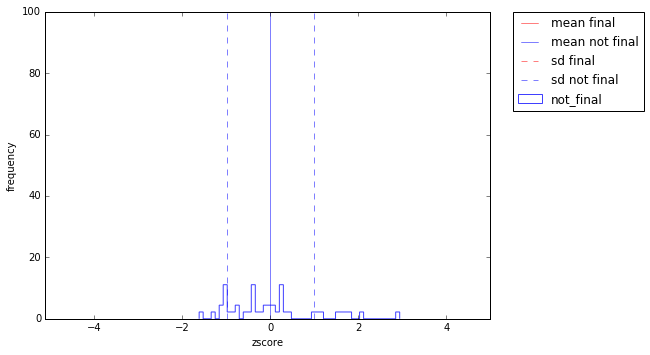

O
mean final  0.176666666667
mean_not_final  -0.00153125
sd final  0.540637483799
sd not final  1.00294402524


2 3
232 320
mean percentile final  0.555
mean percentile not_final  -0.0974568965517
sd percentile final  0.540637483799
sd percentile not final  1.00294402524


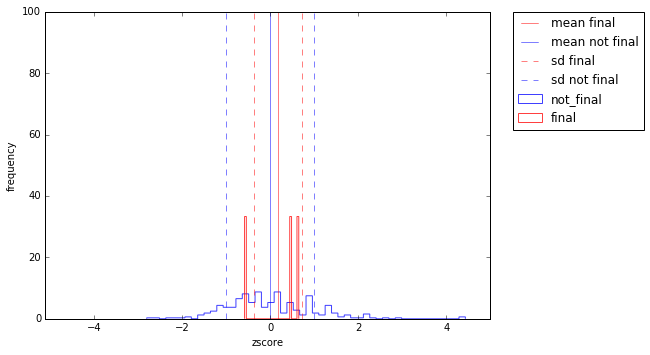

U
mean final  0.06
mean_not_final  -0.00560975609756
sd final  0.971924636996
sd not final  1.00261418168


33 48
348 492
mean percentile final  0.182727272727
mean percentile not_final  0.0333908045977
sd percentile final  0.971924636996
sd percentile not final  1.00261418168


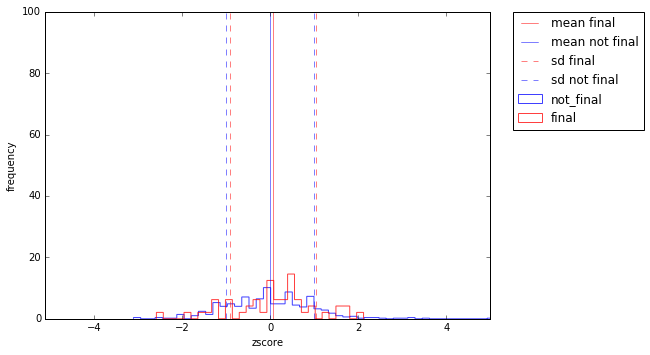

e:
mean final  -0.21
mean_not_final  0.00353260869565
sd final  0.737043644117
sd not final  1.0033360219


4 6
272 368
mean percentile final  -0.715
mean percentile not_final  -0.211985294118
sd percentile final  0.737043644117
sd percentile not final  1.0033360219


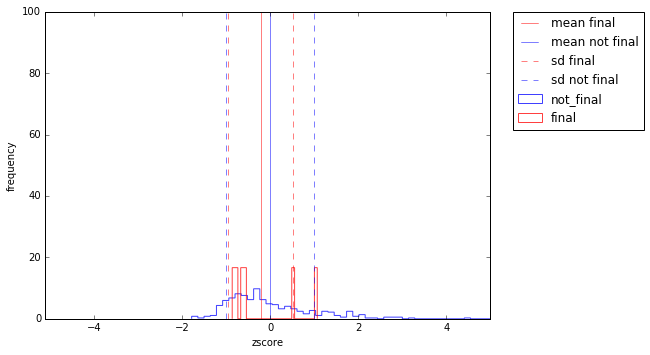

a:
mean final  -0.35
mean_not_final  0.00693251533742
sd final  1.01862652626
sd not final  0.997706776261


2 3
130 163
mean percentile final  -1.06
mean percentile not_final  -0.306461538462
sd percentile final  1.01862652626
sd percentile not final  0.997706776261


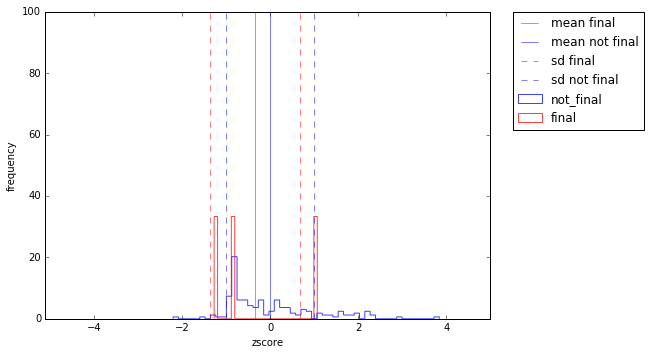

a
mean final  0.09
mean_not_final  -0.000467502850627
sd final  1.04310434122
sd not final  0.999936547772


2 3
737 877
mean percentile final  0.815
mean percentile not_final  -0.25118046133
sd percentile final  1.04310434122
sd percentile not final  0.999936547772


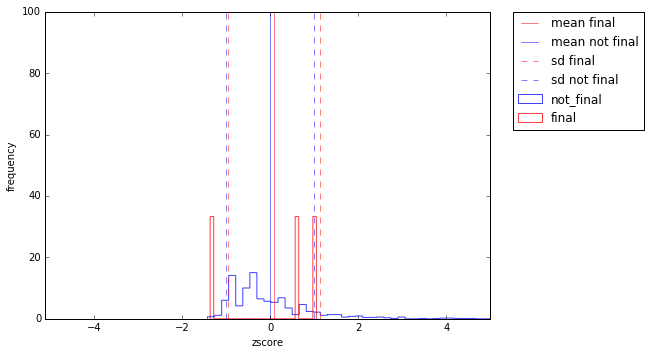

e
mean final  nan
mean_not_final  0.0
sd final  nan
sd not final  0.998770672949


0 0
8 14
mean percentile final  nan
mean percentile not_final  0.27875
sd percentile final  nan
sd percentile not final  0.998770672949


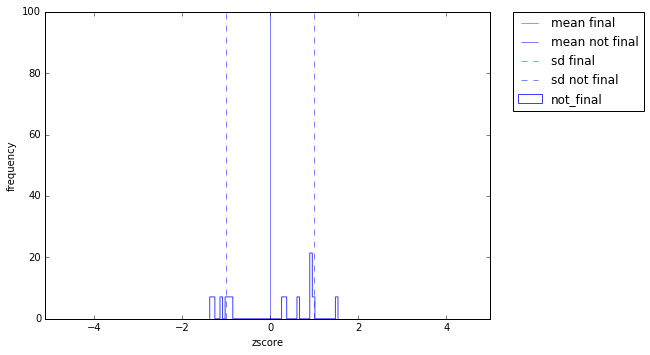

i
mean final  -0.57
mean_not_final  0.0305555555556
sd final  0.460072458061
sd not final  1.00313659324


2 3
39 54
mean percentile final  -0.245
mean percentile not_final  -0.0302564102564
sd percentile final  0.460072458061
sd percentile not final  1.00313659324


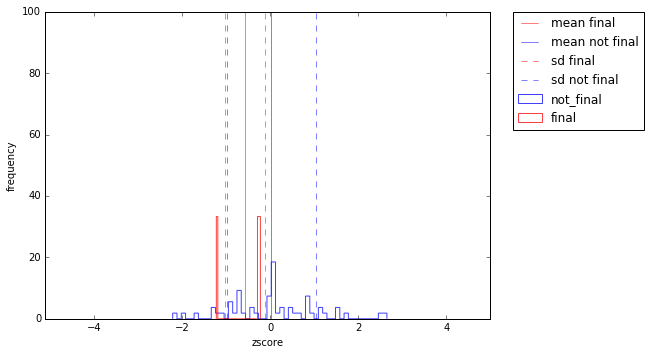

o
mean final  -0.0842857142857
mean_not_final  0.0122916666667
sd final  0.494046184737
sd not final  1.0531188592


4 7
38 48
mean percentile final  -0.11
mean percentile not_final  -0.0713157894737
sd percentile final  0.494046184737
sd percentile not final  1.0531188592


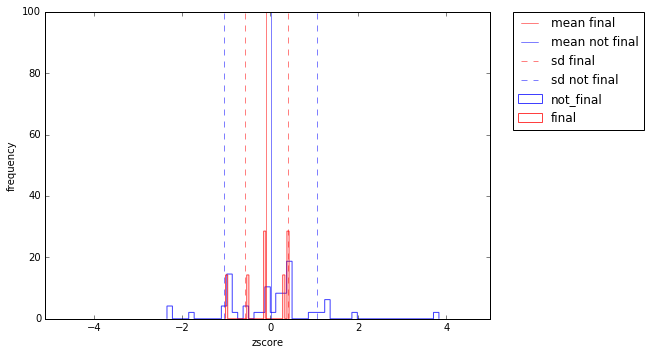

u
mean final  nan
mean_not_final  -3.46944695195e-17
sd final  nan
sd not final  1.00029995501


0 0
3 4
mean percentile final  nan
mean percentile not_final  -0.553333333333
sd percentile final  nan
sd percentile not final  1.00029995501


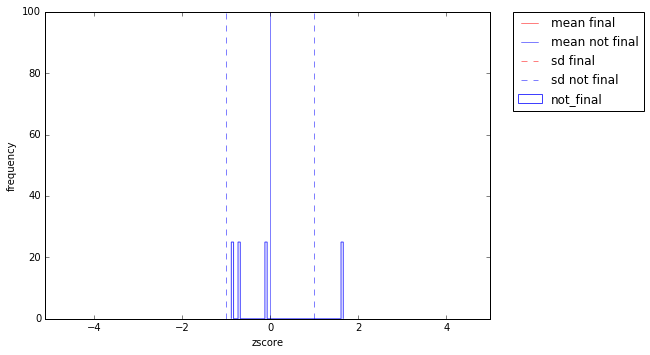

OY
mean final  1.65
mean_not_final  -0.0318
sd final  0.0
sd not final  0.981783458814


0 1
33 50
mean percentile final  nan
mean percentile not_final  -0.128484848485
sd percentile final  0.0
sd percentile not final  0.981783458814


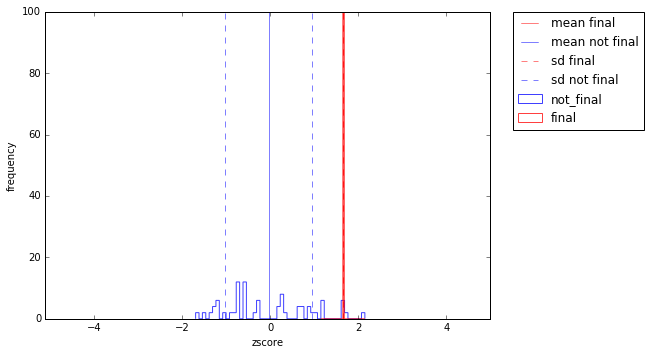

6
mean final  -0.373243243243
mean_not_final  0.0599342105263
sd final  0.496112204255
sd not final  1.04724670139


54 74
385 456
mean percentile final  -0.423703703704
mean percentile not_final  -0.142363636364
sd percentile final  0.496112204255
sd percentile not final  1.04724670139


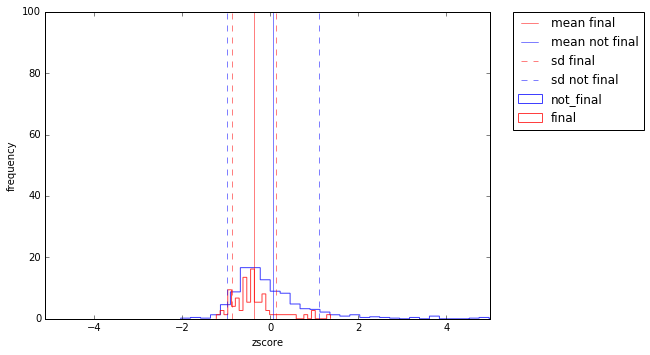

@
mean final  -0.302638888889
mean_not_final  0.0283961661342
sd final  0.781434743589
sd not final  1.01294587449


109 144
1201 1565
mean percentile final  -0.38504587156
mean percentile not_final  -0.143205661948
sd percentile final  0.781434743589
sd percentile not final  1.01294587449


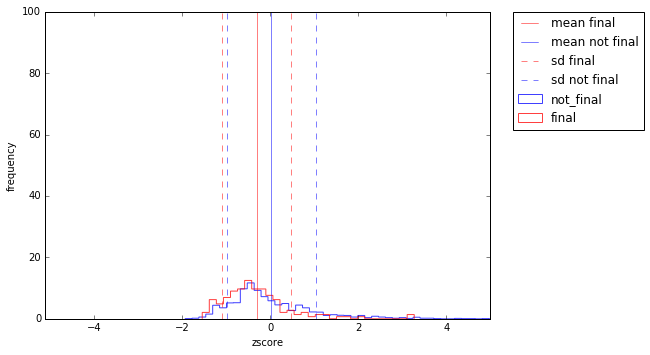

n
mean final  -0.215069444444
mean_not_final  0.0166666666667
sd final  0.721045726443
sd not final  1.01628804556


116 144
1513 1878
mean percentile final  -0.345086206897
mean percentile not_final  -0.225472571051
sd percentile final  0.721045726443
sd percentile not final  1.01628804556


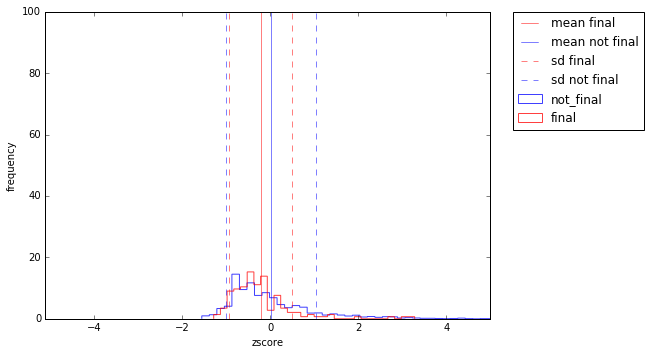

m
mean final  -0.17
mean_not_final  0.00975609756098
sd final  0.685607134485
sd not final  1.01394541587


33 35
547 615
mean percentile final  -0.303333333333
mean percentile not_final  -0.223893967093
sd percentile final  0.685607134485
sd percentile not final  1.01394541587


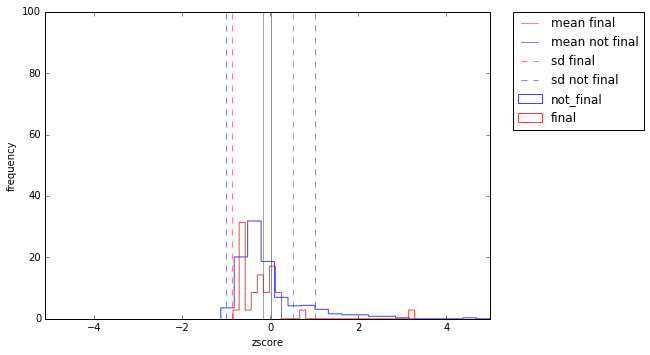

f
mean final  -0.612142857143
mean_not_final  0.0342
sd final  0.773675629442
sd not final  0.999916976554


10 14
168 250
mean percentile final  -0.67
mean percentile not_final  0.0924404761905
sd percentile final  0.773675629442
sd percentile not final  0.999916976554


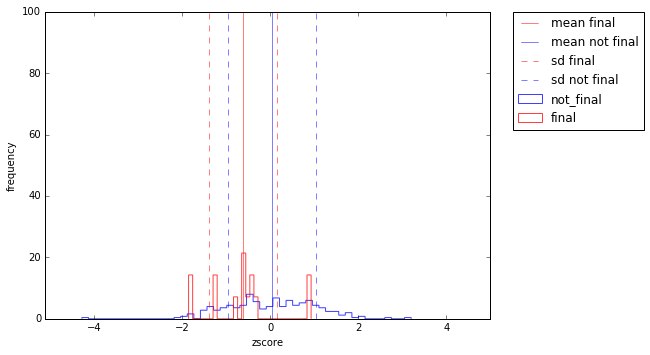

s
mean final  -0.265283687943
mean_not_final  0.051279945243
sd final  0.516546865446
sd not final  1.06098036442


213 282
1146 1461
mean percentile final  -0.308215962441
mean percentile not_final  -0.174616055846
sd percentile final  0.516546865446
sd percentile not final  1.06098036442


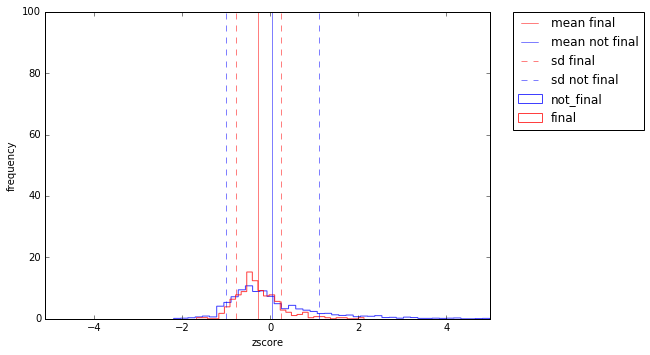

S
mean final  0.029
mean_not_final  -0.00630434782609
sd final  0.885036157453
sd not final  1.01244937328


7 10
29 46
mean percentile final  -0.514285714286
mean percentile not_final  -0.234482758621
sd percentile final  0.885036157453
sd percentile not final  1.01244937328


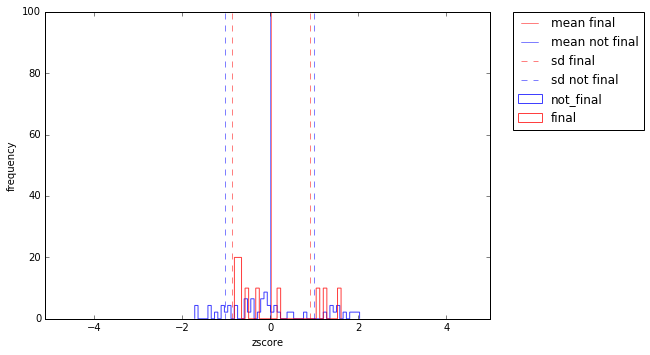

In [116]:
sp=4
feature_dict = zscore_dict
feat_name = 'zscore'
for vow in vowels:
    print vow
    phone_name = vow
    plot_distribution(sp, feature_dict,\
                      x_lim=[-5.1,5], y_lim=[0,100], feature_name=feat_name,\
                      phone_name = phone_name, binf=30, bin_nf=50 ,\
                      bin_num=50, rnd_num=2, cumulative = False)

mean final  -0.494444444444
mean_not_final  0.0750420168067
sd final  0.780941185879
sd not final  1.00844907459


13 18
80 119
mean percentile final  -0.610769230769
mean percentile not_final  -0.027875
sd percentile final  0.780941185879
sd percentile not final  1.00844907459


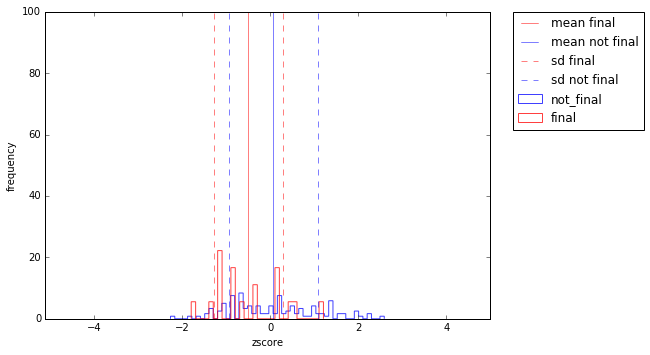

In [83]:
#you can get the distribution of zscore values and duration values
#for all phones (phone_name = '') or a single phone
##################################################
#feature names are: zscore, duration, wml, wml_trigram
#feature dicts are: zscore_dict, duration_dict, wml_dict
sp=4
feature_dict = zscore_dict
feat_name = 'zscore'
phone_name = 'y:'
plot_distribution(sp, feature_dict,\
                     x_lim=[-5.1,5], y_lim=[0,100], feature_name=feat_name,\
                  phone_name = phone_name, binf=30, bin_nf=50 ,\
                  bin_num=50, rnd_num=2, cumulative=False)

mean final  -1.06304757419
mean_not_final  -1.21695618457
sd final  0.244450591065
sd not final  0.217719868366


1444 2123
1892 2579
mean percentile final  -1.08337257618
mean percentile not_final  -1.18655391121
sd percentile final  0.244450591065
sd percentile not final  0.217719868366


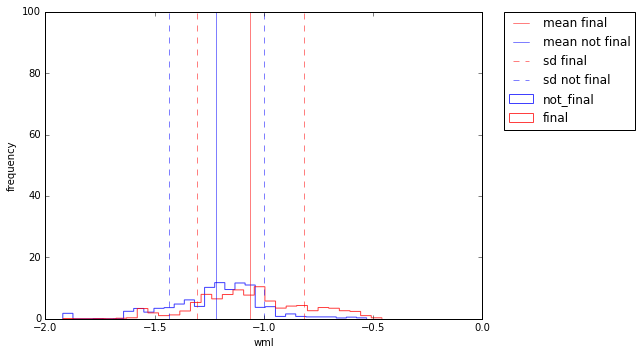

In [119]:
#wml
sp=4
plot_distribution(sp, wml_dict,\
                     x_lim=[-2,0.0], y_lim=[0,100], feature_name='wml',\
                  phone_name = '', binf=30, bin_nf=30 ,\
                  bin_num=50, rnd_num=2, cumulative=False)

mean final  0.1075
mean_not_final  -0.000734649122807
sd final  0.903863236336
sd not final  1.00056245574


2 4
773 912
mean percentile final  0.37
mean percentile not_final  -0.243712807245
sd percentile final  0.903863236336
sd percentile not final  1.00056245574


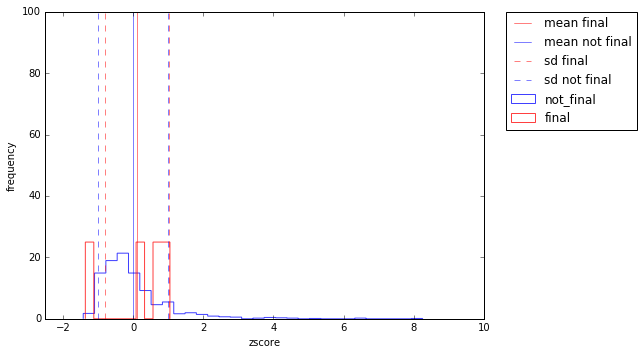

In [35]:
#duration
sp=7
plot_distribution(sp, zscore_dict,\
                     x_lim=[-2.5,10], y_lim=[0,100], feature_name='zscore',\
                  phone_name = 'a', binf=10, bin_nf=30 ,\
                  bin_num=50, rnd_num=2, cumulative=False)

# Plot distribution for values for acoustic features

In [15]:
#rms_dict, logEnergy_dict, intensity_dict,F0_dict, loudness_dict,\
#time_dict = build_feature_dicts_acoustic(ep_path='./../../Data/pickled_episodes')

In [32]:
def get_freq_dist(val_list):    
    freq_dist = collections.Counter(val_list)
    return freq_dist

def get_val_list_acoustic(sp, val_dict,\
                          list_keys=['final','not_final'] ,\
                          feature_name='', final_notfinal=True):
    #if final_notfinal==False:
    #    list_keys = ['pause','speech']
    vals_final = []
    vals_not_final = []
    for speaker in range(2,8):
        if speaker != sp:
            if feature_name == '':
                vals_final += val_dict[str(speaker)][list_keys[0]]
                vals_not_final += val_dict[str(speaker)][list_keys[1]]
            else:
                vals_final += val_dict[str(speaker)][feature_name][list_keys[0]]
                vals_not_final += val_dict[str(speaker)][feature_name][list_keys[1]]
    return vals_final, vals_not_final
    
def plot_acoustic_feature_distribution(speaker, feature_dict,\
                     x_lim, y_lim, feature_name,\
                      binf, bin_nf, bin_num, rnd_num, final_notfinal=True,\
                                       cumulative=True, scatter=False, plot_second_wml=False,\
                         title_plot="", title_pdf='./figures/'):
    
    
    if not os.path.isdir(title_pdf):
        os.makedirs(title_pdf)
    
    ymax = 100
    cat_labels = ['final','not_final']
    
    if final_notfinal == False:
        cat_labels = ['pause','speech']
        val_list_final, val_list_not_final = get_val_list_acoustic(speaker, feature_dict, cat_labels, feature_name, final_notfinal)        
    else:
        if feature_name in ['RMS', 'LOG', 'loudness']:
            val_list_final, val_list_not_final = get_val_list_acoustic(speaker, feature_dict, cat_labels)        
        elif feature_name in ['intensity', 'intensity_mean', 'intensity_slope',\
                              'F0', 'F0_slope']:
            val_list_final, val_list_not_final = get_val_list_acoustic(speaker, feature_dict, cat_labels, feature_name)
        elif feature_name ==  'time':
            cat_labels = ['trp time', 'nothing']
            val_list_final = get_freq_dist(feature_dict[str(speaker)])
            val_list_not_final = [0.0]
        elif "wml" in feature_name or 'entropy' in feature_name:
            if feature_name == "wml":
                feature_name2 = "wml_trigram"
            else:
                feature_name2 = "wml"
            if speaker == "":
                title_pdf += feature_name+'_time_allspeakers'
                start = 2
                end = 8
            else:
                title_pdf += feature_name+'_time_speaker'+str(speaker)
                start = int(speaker)
                end = int(speaker)+1
                
            if scatter:
                title_pdf += '_scatter_plot'
                if not plot_second_wml:
                    title_pdf += "_single"
            if not plot_second_wml:
                    title_pdf += "_single"
            title_pdf += '.pdf'
            leg_lab = []
            with PdfPages(title_pdf) as pdf:
        
                fig = plt.figure(figsize=(7, 5))
                ax = fig.add_axes([0.1, 0.1, 0.6, 0.75])
                print 'speaker\t feature\t slope\t intercept\t r_value\t p_value\t std_err '
                for speaker in range(start,end):
                    N = 50            

                    #colors = np.random.rand(N)
                    #5*np.random.rand(N)
                    area = np.pi * (5 * .1)**2  # 0 to 15 point radii
                    if feature_name == 'entropy':
                        time = np.array([tupel[1] for tupel in feature_dict[str(speaker)][feature_name] if tupel[0]!=0.0])
                        wml = np.array([tupel[0] for tupel in feature_dict[str(speaker)][feature_name] if tupel[0]!=0.0])
                        
                        colors = [int(speaker) for w in wml]
                        if scatter:
                            plt.scatter(time,wml, s=area, c=colors, alpha=0.5)                            
                    else:                        
                        time = np.array([tupel[1] for tupel in feature_dict[str(speaker)][feature_name] if tupel[0]!=-3])
                        wml = np.array([tupel[0] for tupel in feature_dict[str(speaker)][feature_name] if tupel[0]!=-3])
                    
                        colors = [int(speaker) for w in wml]
                        
                        if plot_second_wml:
                            time_tri = np.array([tupel[1] for tupel in feature_dict[str(speaker)][feature_name2] if tupel[0]!=-3])
                            wml_tri = np.array([tupel[0] for tupel in feature_dict[str(speaker)][feature_name2] if tupel[0]!=-3])

                            colors2 = [int(speaker)+7 for w in wml_tri]

                        #plt.scatter(time,wml, s=area, c=colors, alpha=0.5)
                        #plt.scatter(time_tri,wml_tri, s=area, c=colors2, alpha=0.5)

                    slope, intercept, r_value, p_value, std_err = stats.linregress(time,wml)
                    print speaker,'\t', feature_name,"\t\t","{0:.4f}".format(slope),'\t', "{0:.4f}".format(intercept), '\t', "{0:.4f}".format(r_value),\
                    '\t', "{0:.8f}".format(p_value),'\t', "{0:.4f}".format(std_err)
                    
                    if feature_name != 'entropy' and plot_second_wml:
                        slope2, intercept2, r_value2, p_value2, std_err2 = stats.linregress(time_tri,wml_tri)
                        print speaker,'\t', feature_name2,"\t","{0:.4f}".format(slope2),'\t', "{0:.4f}".format(intercept2), '\t', "{0:.4f}".format(r_value2),\
                        '\t', "{0:.8f}".format(p_value2),'\t', "{0:.4f}".format(std_err2)
                    
                    #a simple regression line with numpy:
                    ax.plot(np.unique(time), np.poly1d(np.polyfit(time,wml, 1))(np.unique(time)))
                    leg_lab.append(str(speaker)+' '+feature_name)
                    
                    if feature_name != 'entropy' and plot_second_wml:
                        ax.plot(np.unique(time_tri), np.poly1d(np.polyfit(time_tri,wml_tri, 1))(np.unique(time)), linestyle='--')
                        leg_lab.append(str(speaker)+' '+feature_name2)
                    
                    #plt.legend(leg_lab, bbox_to_anchor=(.87, .46), loc = 2, borderaxespad=0.)
                    ax.legend(leg_lab, bbox_to_anchor=(1.05, 1), loc = 2, borderaxespad=0.)
                    
                    
                if end-start == 6:
                    plt.title(title_plot)
                ax.set_xlabel("time elapsed in episode (in percent)")
                ax.set_ylabel(feature_name)
                
                #plt.tight_layout()
                pdf.savefig()  # saves the current figure into a pdf page
                
            plt.show()            
            return
        else:
            return 'Not a valid feature name'
    
    #print val_list_final
    val_list_final = [round(valf,rnd_num) for valf in val_list_final]
    val_list_not_final = [round(valf,rnd_num) for valf in val_list_not_final]
    
    
    val_meanf = np.mean(val_list_final)
    print 'mean ', cat_labels[0], val_meanf
    
    val_stdf = np.std(val_list_final)
    print 'sd ', cat_labels[0], val_stdf
    
    f_color = 'r'
    
    if feature_name !=  'time':
        val_mean = np.mean(val_list_not_final)
        print 'mean ', cat_labels[1] , val_mean
        val_std = np.std(val_list_not_final)
        print 'sd ', cat_labels[1], val_std
        nf_color = 'b'

    title_pdf += feature_name+'_speaker'+str(speaker)+'.pdf'
    with PdfPages(title_pdf) as pdf:
        
        fig = plt.figure(figsize=(7, 5))
    
        plt.xlim(x_lim[0], x_lim[1])
        plt.ylim(y_lim[0], y_lim[1])


        if len(val_list_final) > 0 and len(val_list_not_final) > 0:
            if feature_name !=  'time':
                n, bins, patches = plt.hist(val_list_not_final, bin_nf ,\
                                            histtype='step', cumulative=cumulative,\
                                            weights=[float(ymax)/len(val_list_not_final)]*len(val_list_not_final),\
                                            facecolor=nf_color, color=nf_color, alpha=0.5, label=cat_labels[1])
            n, bins, patches = plt.hist(val_list_final, binf,\
                                        histtype='step', cumulative=cumulative,\
                                        weights=[float(ymax)/len(val_list_final)]*len(val_list_final),\
                                        facecolor=f_color, color=f_color, alpha=0.5, label=cat_labels[0])
            #else:
            #    #df = pd.DataFrame(val_list_final)
            #    #df.plot(kind='density', color=f_color)
            #    sns.kdeplot(np.array(val_list_final), color=f_color, bw=.5)
        else:
            return 'no values', len(val_list_not_final), len(val_list_final)
        #mean
        ymax = ymax-6
        start_y = 1
        plt.plot([val_meanf, val_meanf], [start_y, ymax+5], color=f_color, marker='*', linestyle='-', linewidth=.5,label='mean '+cat_labels[0])
        if feature_name !=  'time':
            plt.plot([val_mean, val_mean], [start_y, ymax+5], color=nf_color, marker='*', linestyle='-', linewidth=.5,label='mean '+cat_labels[1])

        #standard deviation
        plt.plot([val_meanf-val_stdf, val_meanf-val_stdf], [start_y, ymax+5], color=f_color, linestyle='--', linewidth=.5, label='sd '+cat_labels[0])
        plt.plot([val_meanf+val_stdf, val_meanf+val_stdf], [start_y, ymax+5], color=f_color, linestyle='--', linewidth=0.5)

        if feature_name !=  'time':
            plt.plot([val_mean-val_std, val_mean-val_std], [start_y, ymax+5], color=nf_color, linestyle='--', linewidth=.5, label='sd '+cat_labels[1])
            plt.plot([val_mean+val_std, val_mean+val_std], [start_y, ymax+5], color=nf_color, linestyle='--', linewidth=0.5)

        plt.title('Histogram for '+feature_name+' values')
        plt.ylabel('frequency')
        plt.xlabel(feature_name)

        plt.legend(bbox_to_anchor=(1.05, 1), loc = 2, borderaxespad=0.)
        
        plt.tight_layout()
        pdf.savefig()  # saves the current figure into a pdf page

        ##############################
        
    
    plt.show()
    return

In [33]:
len(wml_time_dict['3']['wml'])

KeyError: '3'

speaker	 feature	 slope	 intercept	 r_value	 p_value	 std_err 


KeyError: '2'

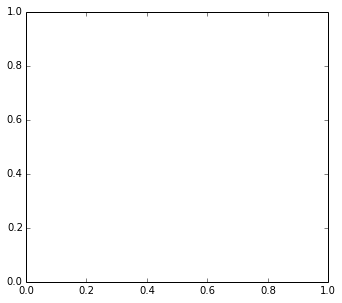

In [34]:
speaker = ""
feature_dict = wml_time_dict
feature_name = 'wml_trigram'
title = "trend lines for WML values\n against "+\
"elapsed time in percent\n"# with regression lines per speaker"
x_lim = [-0.00001,0.0001]
y_lim = [0,100]
plot_acoustic_feature_distribution(speaker, feature_dict,\
                     x_lim, y_lim, feature_name,\
                      binf=100, bin_nf=100, bin_num=3,\
                                   rnd_num=10, final_notfinal=True,\
                                   cumulative=False, scatter=False, plot_second_wml=False, title_plot=title)

mean  pause 2.10337138254e-08
sd  pause 1.3907078018e-07
mean  speech 2.45318276458e-06
sd  speech 3.24071415934e-06


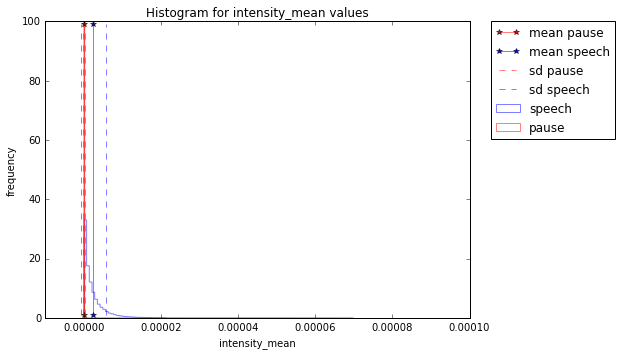

In [24]:
#vad_dict: show distribution of values for label 0|2(pause) and 1(speech)
#vad_dict[speaker][feature][speech|pause] = [list values]
speaker = 3
feature_dict = vad_dict
feature_name = 'intensity_mean'
x_lim = [-0.00001,0.0001]
y_lim = [0,100]
plot_acoustic_feature_distribution(speaker, feature_dict,\
                     x_lim, y_lim, feature_name,\
                      binf=100, bin_nf=100, bin_num=3,\
                                   rnd_num=10, final_notfinal=False, cumulative=False)

mean  final 0.0056790005408
sd  final 0.00931489681186
mean  not_final 0.00302453222484
sd  not_final 0.00700131738766


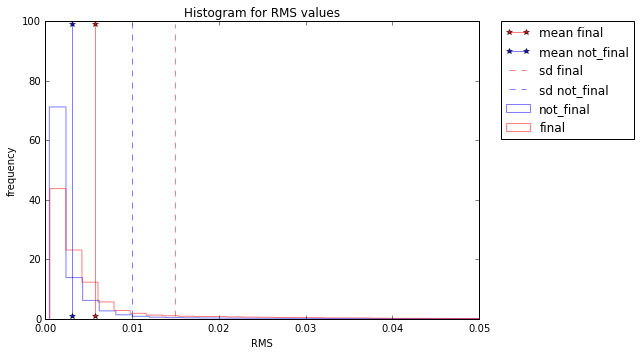

In [25]:
#show distribution of feature values for final|not final word
###############################################
#possible values for feature_name, feature_dict:
#'RMS', 'LOG', 'loudness', 'intensity', 'intensity_mean', 'intensity_slope',
#'F0', 'F0_slope', 'time'
#choose the dictionary respectively:
#rms_dict, logEnergy_dict, loudness_dict, intensity_dict, 
#F0_dict, time_dict
####################
#adjust x_lim according to the values
speaker = 3
feature_dict = rms_dict
feature_name = 'RMS'
x_lim = [0,0.05]
y_lim = [0,100]
plot_acoustic_feature_distribution(speaker, feature_dict,\
                     x_lim, y_lim, feature_name,\
                      binf=100, bin_nf=100, bin_num=3, rnd_num=10, cumulative=False)

mean  trp time 4.7768452381
sd  trp time 2.52342198212


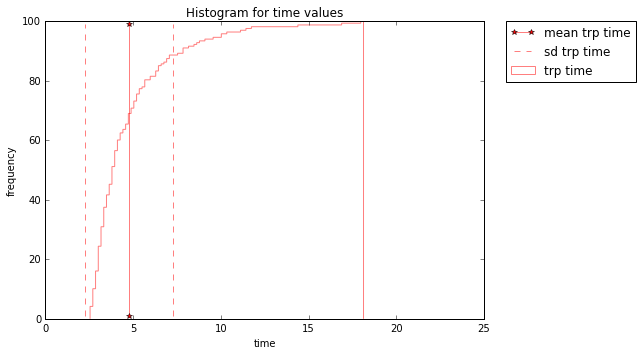

In [26]:
#trp time distribution for a speaker
speaker = 4
feature_dict = time_dict
feature_name = 'time'
x_lim = [0,25]
y_lim = [0,100]
plot_acoustic_feature_distribution(speaker, feature_dict,\
                     x_lim, y_lim, feature_name,\
                      binf=100, bin_nf=100, bin_num=3, rnd_num=10, cumulative=True)

# Tables for Average, standard deviation... 

In [14]:
#started with mean for now...
def create_table():
    feature_dict_list = [('RMS',rms_dict),\
                             ('LOG',logEnergy_dict),\
                             ('loudness',loudness_dict),\
                             (['intensity', 'intensity_mean', 'intensity_slope'],intensity_dict),\
                             (['F0', 'F0_slope'],F0_dict),\
                        ('zscore',zscore_dict),('duration',dur_dict),(['wml','wml_trigram'],wml_dict)]
    
    
    progress_count = 0
    counter = 0
    err_list = []
    
    cat_label= ['final','not_final']
    df_final_notfinal = pd.DataFrame()
    df_final_notfinal['speaker'] = np.array([i for i in range(2,8)])
    df_vad = pd.DataFrame()
    df_vad['speaker'] = np.array([i for i in range(2,8)])
    #or create a dataframe? numpy array?
            
    for feature, val_dict in feature_dict_list:        
        print feature
        if type(feature)==list:
            for feat in feature:
                list_avg_speaker_final = []
                list_avg_speaker_not_final = []
                
                list_vad_avg_pause = []
                list_vad_avg_speech = []
                for speaker in range(2,8):
                    if feat not in ['wml','wml_trigram']:
                        avg_speaker_final = np.mean(val_dict[str(speaker)][feat][cat_label[0]])
                        avg_speaker_not_final = np.mean(val_dict[str(speaker)][feat][cat_label[1]]) 
                        
                        cat_label = ['pause','speech']
                        if feat == 'RMS':
                            feat = 'rms'
                        elif feat == 'LOG':
                            feat = 'LOGenergy'
                        vad_avg_speaker_pause = np.mean(vad_dict[str(speaker)][feat][cat_label[0]])
                        vad_avg_speaker_speech = np.mean(vad_dict[str(speaker)][feat][cat_label[1]]) 
                        list_vad_avg_pause.append(vad_avg_speaker_pause)
                        list_vad_avg_speech.append(vad_avg_speaker_speech)
                        
                        cat_label= ['final','not_final']
                        
                    else:
                        avg_speaker_final = np.mean(val_dict[str(speaker)][cat_label[0]][feat])
                        avg_speaker_not_final = np.mean(val_dict[str(speaker)][cat_label[1]][feat]) 
                        
                    list_avg_speaker_final.append(avg_speaker_final)
                    list_avg_speaker_not_final.append(avg_speaker_not_final)
                    
                df_final_notfinal[feat+'_'+cat_label[0]] = np.array(list_avg_speaker_final)
                df_final_notfinal[feat+'_'+cat_label[1]] = np.array(list_avg_speaker_not_final)   
                
                if feat not in ['wml','wml_trigram']:
                    df_vad[feat+'_pause'] = np.array(list_vad_avg_pause)
                    df_vad[feat+'_speech'] = np.array(list_vad_avg_speech)

        else:
            feat = feature
            list_avg_speaker_final = []
            list_avg_speaker_not_final = []
                
            list_vad_avg_pause = []
            list_vad_avg_speech = []
            for speaker in range(2,8):                
                if feat not in ['zscore','duration']:
                    avg_speaker_final = np.mean(val_dict[str(speaker)]['final'])
                    avg_speaker_not_final = np.mean(val_dict[str(speaker)]['not_final'])   
                    
                    cat_label = ['pause','speech']
                    if feat == 'RMS':
                        feat = 'rms'
                    elif feat == 'LOG':
                        feat = 'LOGenergy'
                    vad_avg_speaker_pause = np.mean(vad_dict[str(speaker)][feat][cat_label[0]])
                    vad_avg_speaker_speech = np.mean(vad_dict[str(speaker)][feat][cat_label[1]]) 
                    list_vad_avg_pause.append(vad_avg_speaker_pause)
                    list_vad_avg_speech.append(vad_avg_speaker_speech)

                    cat_label= ['final','not_final']

                else:
                    val_list_final = []
                    val_list_not_final = []
                    for phone in val_dict['r'+str(speaker)].keys():
                        val_list_final += val_dict['r'+str(speaker)][phone]['final']
                        val_list_not_final += val_dict['r'+str(speaker)][phone]['not_final']
                    avg_speaker_final = np.mean(val_list_final)
                    avg_speaker_not_final = np.mean(val_list_not_final) 

                    #else:
                    #    avg_speaker_final = np.mean(val_dict['r'+str(speaker)]['final'])
                    #    avg_speaker_not_final = np.mean(val_dict['r'+str(speaker)]['not_final']) 

                list_avg_speaker_final.append(avg_speaker_final)
                list_avg_speaker_not_final.append(avg_speaker_not_final)

            df_final_notfinal[feat+'_final'] = np.array(list_avg_speaker_final)
            df_final_notfinal[feat+'_notfinal'] = np.array(list_avg_speaker_not_final)
            
            if feat not in ['zscore','duration']:
                df_vad[feat+'_pause'] = np.array(list_vad_avg_pause)
                df_vad[feat+'_speech'] = np.array(list_vad_avg_speech)
            
    return df_final_notfinal, df_vad

In [28]:
df_final_notfinal, df_vad = create_table()

RMS
LOG
loudness
['intensity', 'intensity_mean', 'intensity_slope']
['F0', 'F0_slope']
zscore
duration
['wml', 'wml_trigram']


In [29]:
print 'feature\t\t\t\t 2\t 3\t 4\t 5\t 6\t 7'
for key in df_final_notfinal.keys():
    if key != 'speaker':
        if len(key)<15:
            sep = '\t\t\t'
        elif len(key)<22:
            sep = '\t\t'
        elif len(key)<30:
            sep = '\t'
        val_list = df_final_notfinal[key].values.tolist()
        print key,sep,'\t'.join(["{0:.2f}".format(val) if round(val,2)!=0.00 else "{0:.2f}".format(val*100000)  for val in val_list])

feature				 2	 3	 4	 5	 6	 7
rms_final 			429.40	193.87	0.01	308.83	445.19	458.02
rms_notfinal 			199.03	293.04	423.78	296.97	243.81	434.65
LOGenergy_final 		-11.98	-12.93	-10.97	-12.26	-11.94	-11.24
LOGenergy_notfinal 		-13.55	-12.82	-12.71	-12.61	-13.29	-12.41
loudness_final 			0.79	0.72	0.76	0.62	0.75	1.16
loudness_notfinal 		0.43	0.54	0.59	0.59	0.55	0.65
intensity_final 		0.23	0.10	0.13	0.08	0.15	0.54
intensity_not_final 		0.07	0.10	0.13	0.13	0.12	0.23
intensity_mean_final 		0.24	0.11	0.14	0.09	0.18	0.54
intensity_mean_not_final 	0.07	0.10	0.13	0.13	0.12	0.22
intensity_slope_final 		-0.02	-0.01	-0.02	-0.02	-0.07	0.03
intensity_slope_not_final 	0.00	0.01	0.00	0.00	0.01	0.02
F0_final 			0.19	0.20	0.11	0.15	0.19	0.22
F0_not_final 			0.18	0.17	0.13	0.15	0.19	0.15
F0_slope_final 			0.01	-0.03	0.01	448.55	-0.01	0.02
F0_slope_not_final 		73.34	0.01	149.83	248.59	202.61	0.01
zscore_final 			-0.12	-0.22	-0.06	-0.24	-0.02	-0.16
zscore_notfinal 		0.01	0.03	0.01	0.02	113.57	0.02
duration_final

In [199]:
df_vad
print 'feature\t\t\t 2\t 3\t 4\t 5\t 6\t 7'
for key in df_vad.keys():
    if key != 'speaker':
        if len(key)>14:
            sep = '\t'
        else:
            sep = '\t\t'
        val_list = df_vad[key].values.tolist()
        print key,sep,'\t'.join(["{0:.2f}".format(val) if round(val,2)!=0.00 else "{0:.2f}".format(val*100000)  for val in val_list])

feature			 2	 3	 4	 5	 6	 7
rms_pause 		74.07	78.96	86.70	90.01	72.58	87.64
rms_speech 		406.63	427.31	0.01	429.28	446.31	0.01
LOGenergy_pause 	-14.47	-14.31	-14.19	-14.08	-14.49	-14.17
LOGenergy_speech 	-11.90	-11.75	-11.46	-11.72	-11.79	-10.88
loudness_pause 		0.20	0.20	0.21	0.24	0.24	0.25
loudness_speech 	0.79	0.81	0.87	0.83	0.90	1.14
intensity_pause 	0.00	0.00	0.00	0.00	0.00	0.00
intensity_speech 	0.18	0.17	0.22	0.21	0.25	0.52
intensity_mean_pause 	0.00	0.00	0.00	0.00	0.00	0.00
intensity_mean_speech 	0.18	0.17	0.21	0.21	0.24	0.51
intensity_slope_pause 	-0.00	-0.00	-0.00	-0.00	-0.00	-0.00
intensity_slope_speech 	0.01	0.01	0.01	0.00	0.01	0.04
F0_pause 		0.12	0.07	0.04	0.08	0.15	0.22
F0_speech 		0.18	0.20	0.16	0.21	0.18	0.16
F0_slope_pause 		-36.74	64.18	-6.33	-11.99	232.82	94.01
F0_slope_speech 	209.54	-332.07	164.53	363.32	-0.01	0.01
